# **\[Essays\]** 강화학습 v2

신록예찬  
2023-08-08

In [3]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import torch 
import collections
import IPython
import random

In [4]:
env = gym.make('LunarLander-v2',render_mode='rgb_array')

In [5]:
class QNetwork(torch.nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.layer1 = torch.nn.Linear(state_size, 128)
        self.layer2 = torch.nn.Linear(128, 64)
        self.layer3 = torch.nn.Linear(64, 32)
        self.layer4 = torch.nn.Linear(32, action_size)
        
    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = torch.nn.functional.relu(self.layer1(state))        
        x = torch.nn.functional.relu(self.layer2(x))
        x = torch.nn.functional.relu(self.layer3(x))
        x = self.layer4(x)
        return x

In [6]:
BUFFER_SIZE = 500*20   # replay buffer size
BATCH_SIZE = 128     # minibatch size
GAMMA = 0.99          # discount factor
LR = 0.0001           # learning rate 
UPDATE_EVERY = 1      # how often to update the network

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = collections.deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = collections.namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)
        
        # Convert to torch tensors
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        
        # Convert done from boolean to int
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)        
        
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [9]:
class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size

        # Q-Network
        self.network = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = torch.optim.Adam(self.network.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        
        
        self.network.eval()
        with torch.no_grad():
            action_values = self.network(state)            
        self.network.train()

        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
        

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        # Obtain random minibatch of tuples from D
        states, actions, rewards, next_states, dones = experiences

        ## Compute and minimize the loss
        ### Extract next maximum estimated value from target network
        q_targets_next = self.network(next_states).detach().max(1)[0].unsqueeze(1)
        q_targets = rewards + gamma * q_targets_next * (1 - dones)

        ### Calculate expected value from local network
        q_expected = self.network(states).gather(1, actions)
        
        loss = torch.nn.functional.mse_loss(q_expected, q_targets)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [10]:
def dqn(n_episodes=2000, max_t=500, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    playtimes=[] 
    scores = []                        # list containing scores from each episode
    scores_window = collections.deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state, _  = env.reset()
        score = 0
        for t in range(max_t):
            ## STEP1: 
            action = agent.act(state, eps)
            
            ## STEP2: 
            next_state, reward, done, _, _ = env.step(action)
            
            ## STEP3: 
            agent.step(state, action, reward, next_state, done)
            
            ## STEP4: 
            state = next_state
            
            ## STEP5: 
            score += reward
            
            if done:
                playtimes.append(t)
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}\tPlaytime: {:.2f}'.format(i_episode, np.mean(scores_window), np.mean(playtimes)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}\tPlaytime: {:.2f}'.format(i_episode, np.mean(scores_window), np.mean(playtimes)))
            torch.save(agent.network.state_dict(), 'checkpoint.pth')
        if np.mean(scores_window)>=200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            torch.save(agent.network.state_dict(), 'checkpoint.pth')
            break
    return scores

In [11]:
env.reset()

In [12]:
agent = Agent(state_size=8, action_size=4, seed=0)
scores = dqn(n_episodes=2000, max_t=500, eps_start=1.00, eps_end=0.05, eps_decay=0.995)

Episode 100 Average Score: -144.21  Playtime: 109.37
Episode 200 Average Score: -47.89   Playtime: 144.204
Episode 300 Average Score: 70.37    Playtime: 154.142
Episode 400 Average Score: 178.30   Playtime: 195.00
Episode 426 Average Score: 200.90   Playtime: 207.62
Environment solved in 426 episodes! Average Score: 200.90

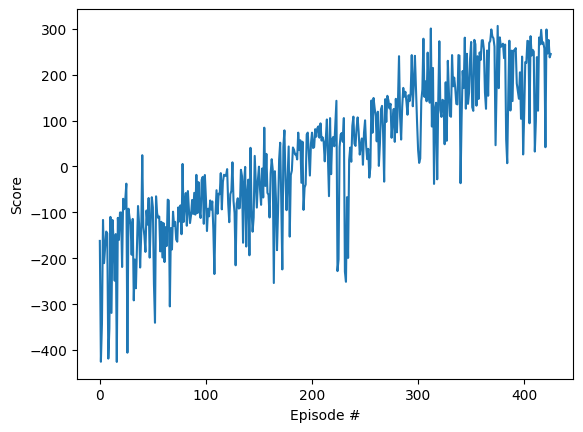

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [14]:
frames = []
agent = Agent(state_size=8, action_size=4, seed=0)
agent.network.load_state_dict(torch.load('checkpoint.pth'))
state,_ = env.reset()
done = False
while not done:
    frames.append(env.render())
    action = agent.act(state)
    state, reward, done, _,_ = env.step(action)
env.close()

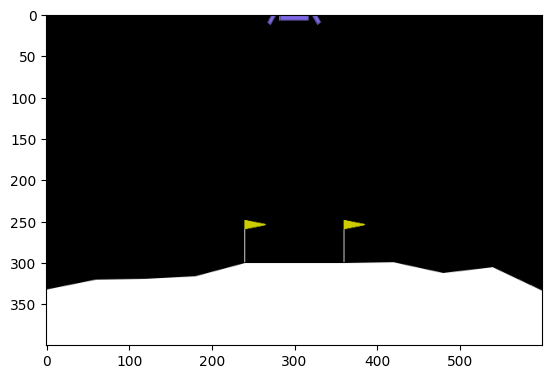

In [15]:
fig, ax = plt.subplots()
ani = FuncAnimation(fig,lambda i: ax.imshow(frames[::10][i]),frames=len(frames[::10]))

`-` 방법1

In [30]:
# ani.save('LunarLander-v2.mp4', writer='ffmpeg', fps=15, extra_args=['-vcodec', 'mpeg4'])

`-` 방법2

In [ ]:
IPython.display.HTML(ani.to_jshtml())